In [240]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acc_sc
from sklearn.metrics import confusion_matrix as conf_mat
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import csv

import sklearn.metrics

In [338]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [339]:
class DatasetVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, utterance_vocab, relation_vocab):
        self.utterance_vocab = utterance_vocab
        self.relation_vocab = relation_vocab

    def vectorize(self, utterance):
        one_hot = np.zeros(len(self.utterance_vocab), dtype=np.float32)
        for token in utterance.split():
            if token not in string.punctuation:
                one_hot[self.utterance_vocab.lookup_token(token)] = 1
        return one_hot   

    def vectorizeTarget(self, target):
        vocab = self.relation_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in target.split():
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot
    
    @classmethod
    def from_dataframe(cls, utterance_df):
        utterance_vocab = Vocabulary(unk_token="@")
        relation_vocab = Vocabulary(add_unk=False)
        
        ### SUBTASK 1
        for index, row in utterance_df.iterrows():
            for word in row.text.split():
                utterance_vocab.add_token(word)
            for x in row.label.split():
                relation_vocab.add_token(x)    
                
                ### SUBTASK C
#         for index, row in utterance_df.iterrows():
#             for word in row.tweet.split():
#                 utterance_vocab.add_token(word)
#             for x in row.subtask_c.split():
#                 relation_vocab.add_token(x)            

        return cls(utterance_vocab, relation_vocab)

    @classmethod
    def from_serializable(cls, contents):
        utterance_vocab = Vocabulary.from_serializable(contents['utterance_vocab'])
        relation_vocab =  Vocabulary.from_serializable(contents['relation_vocab'])
        return cls(utterance_vocab=utterance_vocab, relation_vocab=relation_vocab)

    def to_serializable(self):
        return {'utterance_vocab': self.utterance_vocab.to_serializable(),
                'relation_vocab': self.relation_vocab.to_serializable()}
    

In [340]:
class UtteranceDataset(Dataset):
    def __init__(self, utterance_df, vectorizer, trainWhole):

        self.utterance_df = utterance_df
        self._vectorizer = vectorizer
        if trainWhole:
            self.train_df = self.utterance_df
            self.train_size = len(self.train_df)
        else:
            self.train_df = self.utterance_df[self.utterance_df.split=='train']
            self.train_size = len(self.train_df)

        self.val_df = self.utterance_df[self.utterance_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.utterance_df[self.utterance_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, utterance_csv, trainWhole):
        
        ### SUBTASK C
#         utterance_df = pd.read_csv(utterance_csv, sep='\t')
#         utterance_df = utterance_df[utterance_df["subtask_b"] == "TIN"]
#         msk = np.random.rand(len(utterance_df)) < 0.92
#         train_df = utterance_df[msk]
#         train_df['split'] = 'train'
#         val_df = utterance_df[~msk]
#         val_df['split'] = 'val'
#         utterance_df = train_df.append(val_df, ignore_index=True)
#         train_utterance_df = utterance_df[utterance_df.split=='train']
#         VAL_Big = val_df
#         return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df), trainWhole)


        ###SUBTASK 1
        utterance_df = pd.read_csv(utterance_csv, sep='\t')
        train_df = utterance_df
        train_df['split'] = 'train'
        val_df = pd.read_csv("246_data/dev.tsv", sep='\t')
        val_df['split'] = 'val'
        val_df = val_df.dropna()
        utterance_df = train_df.append(val_df, ignore_index=True)
        return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df), trainWhole)

        
        
        ##SUBTASK 2
#         utterance_df = pd.read_csv(utterance_csv, sep='\t')
#         utterance_df = utterance_df.dropna()
#         train_df = utterance_df
#         train_df['split'] = 'train'
#         val_df = pd.read_csv("246_data/dev.tsv", sep='\t')
#         val_df['split'] = 'val'
#         val_df = val_df[val_df["category"] == "TIN"]
#         utterance_df = train_df.append(val_df, ignore_index=True)
#         return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df), trainWhole)

        ### SUBTASK C
#         utterance_df = pd.read_csv(utterance_csv)
#         train_utterance_df = utterance_df[utterance_df.split=='train']
#         return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df), trainWhole)

    @classmethod
    def load_dataset_and_load_vectorizer(cls, utterance_csv, vectorizer_filepath):
        
        
        ### SUBTASK C
#         utterance_df = pd.read_csv(utterance_csv, sep='\t')
#         utterance_df = utterance_df[utterance_df["subtask_b"] == "TIN"]
#         msk = np.random.rand(len(utterance_df)) < 0.92
#         train_df = utterance_df[msk]
#         train_df['split'] = 'train'
#         val_df = utterance_df[~msk]
#         val_df['split'] = 'val'
#         utterance_df = train_df.append(val_df, ignore_index=True)
#         train_utterance_df = utterance_df[utterance_df.split=='train']
#         return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df))


#         ###SUBTASK 1
        utterance_df = pd.read_csv(utterance_csv, sep='\t')
        train_df = utterance_df
        train_df['split'] = 'train'
        val_df = pd.read_csv("246_data/dev.tsv", sep='\t')
        val_df['split'] = 'val'
        val_df = val_df.dropna()
        utterance_df = train_df.append(val_df, ignore_index=True)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(utterance_df, vectorizer)

        
        
        ###SUBTASK 2
#         utterance_df = pd.read_csv(utterance_csv, sep='\t')
#         utterance_df = utterance_df.dropna()
#         train_df = utterance_df
#         train_df['split'] = 'train'
#         val_df = pd.read_csv("246_data/dev.tsv", sep='\t')
#         val_df['split'] = 'val'
#         val_df = val_df[val_df["category"] == "TIN"]
#         utterance_df = train_df.append(val_df, ignore_index=True)
#         vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
#         return cls(utterance_df, vectorizer)        


        ### Fox Task
#         utterance_df = pd.read_csv(utterance_csv)
#         train_utterance_df = utterance_df[utterance_df.split=='train']
#         return cls(utterance_df, DatasetVectorizer.from_dataframe(utterance_df))

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        
        with open(vectorizer_filepath) as fp:
            return DatasetVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):

        row = self._target_df.iloc[index]
        
        utterance_vec = \
            self._vectorizer.vectorize(row.text)        
        
        ### SUBTASK 1
        relation_vec = \
            self._vectorizer.vectorizeTarget(row.label)
        
        ###SUBTASK 2
#         relation_vec = \
#             self._vectorizer.vectorizeTarget(row.category)

        ### SUBTASK 3     
#         utterance_vec = \
#             self._vectorizer.vectorize(row.tweet)         
#         relation_vec = \
#             self._vectorizer.vectorizeTarget(row.subtask_c)
        
        return {'x_utterance': utterance_vec,
                'y_relation': relation_vec}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [341]:
class RelationClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RelationClassifier, self).__init__()
        self.batch0 = nn.BatchNorm1d(input_dim)
        self.drop0 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.drop1 = nn.Dropout(0.3)
        self.batch1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.drop2 = nn.Dropout(0.1)
        self.batch2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.batch3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 


    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x = self.fc1(x_in)
#         x = self.drop0(x)
        x = F.relu6(x)
        x = self.batch1(x)
        x = self.fc2(x)
#         x = self.drop1(x)
        x = F.relu6(x)
        x = self.batch2(x)
        x = self.fc2(x)
#         x = self.drop2(x)
        x = F.relu6(x)
        x = self.batch3(x)
        prediction_vector = self.fc4(x)
           
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [342]:
def make_train_state(args):
    return {'stop_early': True,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    return n_correct / len(y_pred) * 100

In [343]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)


In [382]:
args = Namespace(
    # Data and path information
    train_csv="246_data/train.tsv",
#       train_csv = "fox_train_val.csv",
#     train_csv="246_data/offenseval-training-v1.tsv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=250,
    # Training  hyper parameters
    seed=1338,
    num_epochs=7,
    early_stopping_criteria=5,
    learning_rate=0.01,
    batch_size=128,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch4/surname_mlp/vectorizer.json
	model_storage/ch4/surname_mlp/model.pth
Using CUDA: False


In [383]:
threshold = 0.3

In [388]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = UtteranceDataset.load_dataset_and_load_vectorizer(args.train_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = UtteranceDataset.load_dataset_and_make_vectorizer(args.train_csv, True)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = RelationClassifier(input_dim=len(vectorizer.utterance_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.relation_vocab))


Creating fresh!


In [389]:
classifier = classifier.to(args.device)
loss_func = nn.MultiLabelSoftMarginLoss()

optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_utterance'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_relation'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred > threshold, batch_dict['y_relation'])
#             acc_t = f1(batch_dict['y_relation'], y_pred > threshold, average="samples")
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_utterance'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_relation'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            
            acc_t = compute_accuracy(y_pred > threshold, batch_dict['y_relation'])
#             acc_t = f1(batch_dict['y_relation'], y_pred > threshold, average="samples")
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


/Users/zbtosh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/Users/zbtosh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/zbtosh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [358]:
## Subtask 1
df = pd.read_csv("246_data/dev.tsv", sep="\t")

# Subtask 2
# df = df.dropna()

### Subtask C
# df = pd.read_csv("246_data/offenseval-training-v1.tsv", sep="\t")
# df = df[df["subtask_b"] == "TIN"]
# preds = []
# labels = []
# for index, row in VAL_Big.iterrows(): 
#     prediction = predict_nationality(row["tweet"], classifier, vectorizer)
#     labels.append(row["subtask_c"])
#     preds.append(prediction)

In [359]:
def predict_abuse(instance, classifier, vectorizer):
    vectorized_instance = vectorizer.vectorize(instance)
    vectorized_instance = torch.tensor(vectorized_instance).view(1, -1)
    result = classifier(vectorized_instance, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nabuse = vectorizer.relation_vocab.lookup_index(index)
    probability_value = probability_values.item()
    return predicted_nabuse

In [326]:
preds = []
labels = []
for index, row in df.iterrows(): 
    prediction = predict_abuse(row["text"], classifier, vectorizer)
    labels.append(row["category"])
    preds.append(prediction)
    
# preds = []
# labels = []
# for index, row in df.iterrows(): 
#     prediction = predict_abuse(row["tweet"], classifier, vectorizer)
#     labels.append(row["subtask_c"])
#     preds.append(prediction)

In [327]:
len(preds)

440

In [328]:
len(labels)

440

In [329]:
f1(labels, preds, pos_label="TIN")

0.9417475728155339

In [330]:
agree = []
agreeIndices = []
disagreeIndices = []
i = 0
for x,y in zip(preds,labels):
    if x == y:
        agree.append(1)
        agreeIndices.append(i)
    else:
        agree.append(0)
        disagreeIndices.append(i)
    i += 1
accuracy = sum(agree) / len(labels)
print("accuracy: ", accuracy)

accuracy:  0.8909090909090909


In [331]:
for i in disagreeIndices:
    print("tweet: ", df.iloc[i]["text"])
    print("prediction: ", preds[i])
    print("label: ", labels[i])
    
# for i in disagreeIndices:
#     print("tweet: ", df.iloc[i]["tweet"])
#     print("prediction: ", preds[i])
#     print("label: ", labels[i])

tweet:  @USER She should ask a few native Americans what their take on this is.
prediction:  TIN
label:  UNT
tweet:  @USER Someone should'veTaken" this piece of shit to a volcano. 😂"
prediction:  TIN
label:  UNT
tweet:  @USER @USER @USER She?  To whom are you referring to?  Hillary?  You know what is tiresome?  Bernie supporters bashing Hillary Clinton.  She is an actual Democrat who raises money for the Democratic Party and doesn’t bash them.  She has a positive message.  So who is dividing the left?
prediction:  TIN
label:  UNT
tweet:  @USER it's literally a narrative that is on par with Nazis punch, antifa punch, they are two sides of the same coin." noooOOoOo one of these groups wants to exterminate or deport all PoC and Jews, the other just wants to prevent them from doing that, and this comparison benefits fash"
prediction:  TIN
label:  UNT
tweet:  @USER Dont believe the hype.
prediction:  TIN
label:  UNT
tweet:  @USER Yeah we need some more made up bullshit protestors and antifa

In [332]:
for i in agreeIndices:
    print("tweet: ", df.iloc[i]["text"])
    print("prediction: ", preds[i])
    print("label: ", labels[i])

# for i in agreeIndices:
#     print("tweet: ", df.iloc[i]["tweet"])
#     print("prediction: ", preds[i])
#     print("label: ", labels[i])

tweet:  @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
prediction:  TIN
label:  TIN
tweet:  @USER Liberals are all Kookoo !!!
prediction:  TIN
label:  TIN
tweet:  @USER @USER Oh noes! Tough shit.
prediction:  UNT
label:  UNT
tweet:  @USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism
prediction:  TIN
label:  TIN
tweet:  @USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo
prediction:  TIN
label:  TIN
tweet:  @USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL
prediction:  TIN
label:  TIN
tweet:  @USER @USER @USER gun control! That is all these kids are asking for!
prediction:  TIN
label:  TIN
tweet:  @USER @USER @USER @USER LOL!!!   Throwing the BULLSHIT Flag on such nonsense!!  #PutUpOrShutUp   #Kav

label:  TIN
tweet:  @USER @USER If Kavanaugh is confirmed there will be two sexual deviants sitting on the Supreme Court. Both Conservatives and nominated by Republicans. Democrats put women on the SCOTUS and Republicans put perverted men there. FOR THEIR LIFETIME! #StopKavanaugh #StopTrump #SaveSCOTUS
prediction:  TIN
label:  TIN
tweet:  @USER @USER Liberals have no shame. To them the outcome justifies the mean
prediction:  TIN
label:  TIN
tweet:  @USER Coming from a guy who worries more about straws than cleaning up failed 'shitty' policies..now he knows best..lol
prediction:  TIN
label:  TIN
tweet:  @USER @USER Popular side doesn’t equal winning side. Facts are that private schools do a much better job educating students than public schools. Public school teachers get unfair perks that they don’t deserve. It’s unfair to private school teachers.
prediction:  TIN
label:  TIN
tweet:  @USER I suppose you think the way liberals attacked Sarah Palin was courageous also. You’re just anothe

In [164]:
len(disagreeIndices)

370

In [364]:
fox_news = pd.read_json("246_data/full-comments-u.json", lines=True)

In [390]:
preds = []
labels = []
for index, row in fox_news.iterrows():
    prediction = predict_abuse(row["text"], classifier, vectorizer)
    if row["label"] == 1:
        labels.append("OFF")
    else:
        labels.append("NOT")
    preds.append(prediction)  
print(len(labels))
print(len(preds))

1528
1528


In [391]:
agree = []
agreeIndices = []
disagreeIndices = []
i = 0
for x,y in zip(preds,labels):
    if x == y:
        agree.append(1)
        agreeIndices.append(i)
    else:
        agree.append(0)
        disagreeIndices.append(i)
    i += 1
accuracy = sum(agree) / len(labels)
print("accuracy: ", accuracy)

accuracy:  0.6989528795811518


In [392]:
f1(labels, preds,pos_label="OFF")

0.23588039867109634

In [352]:
len(disagreeIndices)

494

In [353]:
len(agreeIndices)

1034

In [360]:
fox_news[['text', 'label']].to_csv("Fox_Set")

In [361]:
utterance_df[["text", "label", "split"]].to_csv("fox_train_val.csv")

In [362]:
fox = pd.read_csv("fox_train_val.csv")
fox_news = fox[fox["split"] == "val"]
fox_news

,Unnamed: 0,text,label,split
1399,1399,"She said ""GO"", not ""NO"" ~ ~ Slime ball Lawyers...",0,val
1400,1400,"Imagine that, Muslims are the problem...?",1,val
1401,1401,when no doesn't work...it is advisable to have...,0,val
1402,1402,Merkels legacy. soon to come to your city.,0,val
1403,1403,Why are liberals always against deporting fore...,0,val
...,...,...,...,...
1523,1523,It's a COOKBOOK!,0,val
1524,1524,"FL protects alligators too much, alligators ar...",0,val
1525,1525,i blame the parents for this childs death putt...,0,val
1526,1526,"I agree...you know, the other thing is this: s...",1,val


In [231]:

preds = []
labels = []
for index, row in fox_news.iterrows():
    prediction = predict_abuse(row["text"], classifier, vectorizer)
    labels.append(row["label"])
    preds.append(prediction)  
print(len(labels))
print(len(preds))

129
129


In [232]:
agree = []
agreeIndices = []
disagreeIndices = []
i = 0
for x,y in zip(preds,labels):
    if x == y:
        agree.append(1)
        agreeIndices.append(i)
    else:
        agree.append(0)
        disagreeIndices.append(i)
    i += 1
accuracy = sum(agree) / len(labels)
print("accuracy: ", accuracy)

accuracy:  0.7596899224806202


In [270]:
f1(labels, preds, pos_label="OFF")

0.47592067988668557

In [222]:
preds

['NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',


In [223]:
labels

['NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'OFF',
 'OFF',
 'NOT',
 'OFF',
 'OFF',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'OFF',
 'NOT',
 'NOT',
 'NOT',
 'NOT',


In [394]:
conf_mat(labels, preds)

array([[997,  96],
       [364,  71]])

In [395]:
tn, fp, fn, tp = conf_mat(labels, preds).ravel()

In [396]:
print(tn)
print(fp)
print(fn)
print(tp)

997
96
364
71


In [268]:
cm = conf_mat(labels, preds)

In [398]:
sklearn.metrics.recall_score(labels, preds, pos_label="OFF")

0.1632183908045977

In [400]:
sklearn.metrics.precision_score(labels, preds, pos_label="OFF")

0.4251497005988024

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix MLP - Prediciton 3", None)

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

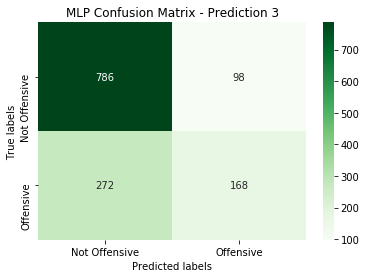

In [404]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('MLP Confusion Matrix - Prediction 3'); 
ax.xaxis.set_ticklabels(['Not Offensive', 'Offensive']); ax.yaxis.set_ticklabels(['Not Offensive', 'Offensive']);



In [407]:
fig = hm.get_figure()
fig.savefig("out") 